In [28]:
# Paper Name: Differential Learning and Control for Molecular Dynamics 

# Abstract: 

# Introduction: 

# Method: 

In [ ]:
# Example Notebook to do Adjoint integration fro backpropagate throught Molecular Dynamics for Learning and Control 

In [3]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import sys 

NFF_PATH = '/home/wwj/Repo/playgrounds/NeuralForceField/'
ODE_PATH = '/home/wwj/Repo/projects/torchdiffeq/'

sys.path.insert(0, NFF_PATH)
sys.path.insert(0, ODE_PATH)

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate
from nff.utils import batch_to
from torchdiffeq import odeint

# Train a Ethanol molecules 

In [4]:
dataset = Dataset.from_file(NFF_PATH + 'tutorials/data/dataset.pth.tar')
train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)
train_loader = DataLoader(train, batch_size=1, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=1, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=1, collate_fn=collate_dicts)

loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.01, 'energy_grad': 1})

In [5]:
params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True
}

model = get_model(params)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]

In [6]:
OUTDIR='ode'

train_hooks = [
    hooks.MaxEpochHook(100),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks
)

In [7]:
T.train(device=1, n_epochs=10)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | GPU Memory (MB)
26:41 |     1 |     3.000e-04 |   108.5575 |         81.3195 |     4.7210 |          6.2875 |               0
26:55 |     2 |     3.000e-04 |    32.0311 |         47.6523 |     6.9382 |          4.9648 |               0
27:08 |     3 |     3.000e-04 |    23.5014 |         32.1302 |     5.6344 |          4.0935 |               0
27:22 |     4 |     3.000e-04 |    18.8905 |         25.3770 |     4.3476 |          3.6474 |               0
27:35 |     5 |     3.000e-04 |    15.3698 |         20.0746 |     3.5514 |          3.2997 |               0
27:49 |     6 |     3.000e-04 |    13.0227 |         16.0783 |     2.8791 |          3.0008 |               0
28:02 |     7 |     3.000e-04 |    11.4575 |         13.3461 |     2.2604 |          2.7626 |               0
28:15 |     8 |     3.000e-04 |    10.2671 |         11.6989 |     1.5124 |          2.5894 |               0
28:28 |   

# Write a Symplectic differential equation (Hamiltonian Equations of motions )

In [10]:
from nff.utils.scatter import compute_grad
from torchdiffeq import odeint_adjoint as odeint
from nff.nn.graphop import batch_and_sum
from ase import Atoms

class ODE(torch.nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model  # declarce model that outputs a dictionary with key ['energy']
        atoms = Atoms(numbers=batch['nxyz'][:, 0].detach().cpu().numpy())#.get_mass()
        self.mass = torch.Tensor(atoms.get_masses()).to(DEVICE)
        
    def forward(self, t, pq):
        # pq are the canonical momentum and position variables
        with torch.set_grad_enabled(True):
            pq.requires_grad = True
            N = int(pq.shape[0]//2)
            
            p = pq[:N]
            q = pq[N:]
            
            q = q.reshape(-1, 3)
            r, N, q = model.convolve(batch, q)
            r = model.atomwisereadout(r)
            results = batch_and_sum(r, N, list(batch.keys()), q)
            
            # compute momentum and forces 
            v = (p.reshape(-1, 3) / self.mass[:, None]).reshape(-1)
            f = -compute_grad(inputs=q, output=results["energy"]).reshape(-1)
        return torch.cat((f, v))

In [16]:
# Initialize initial data:
# get model and batch 

DEVICE = 1
model = T.get_best_model().to(DEVICE)
batch = batch_to( next(iter(train_loader)), DEVICE )
batch.pop("energy_grad") # remove the energy_grad label

# declare a time variables as a tensor (you do not need to make the time step even)
t = torch.Tensor([0.05 * i for i in range(15)]).to(DEVICE)
t.requires_grad=True

# declare position and momentum as initial values
# velocity is zero 
xyz = batch['nxyz'][:, 1:4].reshape(-1)
p = torch.zeros(xyz.shape[0]).to(DEVICE)
pq = torch.cat((p, xyz))
pq.requires_grad= True

f_x = ODE(model)

In [17]:
# Train a model that controls the C-C-O angle

In [18]:
from ase import io 
from datetime import datetime

In [20]:
from ase import io 
from ase import Atoms
from datetime import datetime

# define optimizer 
trainable_params = filter(lambda p: p.requires_grad, f_x.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

for i in range(10):
    print('epoch {}'.format(i))
    current_time = datetime.now() 
    
    if i != 0:
        pq = torch.Tensor(x[-1, :].detach().cpu().numpy()).to(DEVICE)
    
    x = odeint(f_x, pq, t)
    print('epoch {} Finish integration'.format(i))
    
    # control CCO angle 
    xyz = x[:, 27:].reshape(-1, 9, 3)
    d1 = xyz[:, 1, :] - xyz[:, 0, :] 
    d2 = xyz[:, 2, :] - xyz[:, 0, :]
    dot = (d2 * d1).sum(1) / (d2.pow(2).sum(-1).sqrt() * d1.pow(2).sum(-1).sqrt())
    loss = (dot.acos() - 2.8).pow(2).mean() # force the angle to be 90 degrees  
    
    loss.backward()
    print('epoch {} backpropgate through simulations'.format(i))
    optimizer.step()
    optimizer.zero_grad()
    print('epoch {} loss: {}'.format(i,loss.item()) )
    
    dt = (datetime.now() - current_time)
    print( "{} seconds".format(dt.total_seconds())) 
    
    # saving trajectory 
    traj = x[:, 27:].detach().cpu().numpy()
    io.write("./CCO_ode_angle{}.pdb".format(i),[Atoms(numbers=batch['nxyz'][:, 0].detach().cpu().numpy(),
               positions=frame.reshape(-1, 3)) for frame in traj] )

epoch 0
epoch 0 Finish integration
epoch 0 backpropgate through simulations
epoch 0 loss: 0.5952353477478027
17.672934 seconds
epoch 1
epoch 1 Finish integration
epoch 1 backpropgate through simulations
epoch 1 loss: 0.5751432776451111
17.529625 seconds
epoch 2
epoch 2 Finish integration
epoch 2 backpropgate through simulations
epoch 2 loss: 0.5150354504585266
16.594074 seconds
epoch 3
epoch 3 Finish integration
epoch 3 backpropgate through simulations
epoch 3 loss: 0.4469428062438965
16.181444 seconds
epoch 4
epoch 4 Finish integration
epoch 4 backpropgate through simulations
epoch 4 loss: 0.4807685613632202
16.38183 seconds
epoch 5
epoch 5 Finish integration
epoch 5 backpropgate through simulations
epoch 5 loss: 0.3609917461872101
16.161476 seconds
epoch 6
epoch 6 Finish integration
epoch 6 backpropgate through simulations
epoch 6 loss: 0.39178863167762756
17.056332 seconds
epoch 7
epoch 7 Finish integration
epoch 7 backpropgate through simulations
epoch 7 loss: 0.3412429392337799
17

# Visualize Trained Traj

In [1]:
import mdtraj
from nglview import show_ase, show_file, show_mdtraj

# plot the angle as a function trajectory 
traj = mdtraj.join( [ mdtraj.load_pdb("CCO_ode_angle{}.pdb".format(i)) for i in range(10)] )
view = show_mdtraj(traj)
traj.save_pdb('./learned_traj.pdb')

_ColormakerRegistry()

In [3]:
# require nglview
view

NGLWidget(max_frame=149)

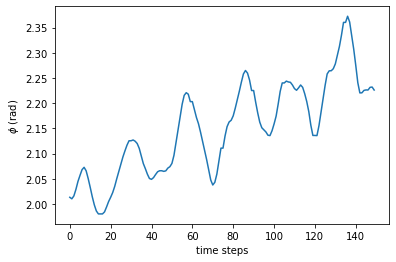

In [27]:
xyz = torch.Tensor( traj.xyz )
d1 = xyz[:, 1, :] - xyz[:, 0, :] 
d2 = xyz[:, 2, :] - xyz[:, 0, :]
dot = (d2 * d1).sum(1) / (d2.pow(2).sum(-1).sqrt() * d1.pow(2).sum(-1).sqrt())

plt.ylabel("$\phi$ (rad)")
#plt.ylim(1.8, 3.0)

plt.xlabel("time steps")
plt.plot( dot.acos() )